In [1]:
#importing to download youtube videos
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time

# Importing Pandas to create DataFrame
import pandas as pd
# Importing numpy
import numpy as np

#importing for plot data visualization
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
#function to scrap youtube commentr from video and returns as dataframe df
def ScrapComment(url):
    option = webdriver.ChromeOptions()
    option.add_argument("--headless")
    driver = webdriver.Chrome(executable_path=ChromeDriverManager().install(), options=option)
    driver.get(url)
    time.sleep(10)
    prev_h = 0
    while True:
        height = driver.execute_script("""
                function getActualHeight() {
                    return Math.max(
                        Math.max(document.body.scrollHeight, document.documentElement.scrollHeight),
                        Math.max(document.body.offsetHeight, document.documentElement.offsetHeight),
                        Math.max(document.body.clientHeight, document.documentElement.clientHeight)
                    );
                }
                return getActualHeight();
            """)
        driver.execute_script(f"window.scrollTo({prev_h},{prev_h + 200})")
        # fix the time sleep value according to your network connection
        time.sleep(1)
        prev_h +=300  
        if prev_h >= height:
            break
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()
    title_text_div = soup.select_one('#container h1')
    title = title_text_div and title_text_div.text
    comment_div = soup.select("#content #content-text")
    comment_list = [x.text for x in comment_div]
    print(title, comment_list)
    df =pd.DataFrame(comment_list,columns=['comments'])
    df["sentiments"] = ""

    return df



In [3]:
#importing string,nltk and re for text preprocessing
import string
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

#function that processes the comments and returns clean_comments as df

def text_preprocessing(data):   

    #convert to lowercase
    data['clean_comments'] = data['comments'].str.lower()

    #removing empty columns
    data['clean_comments'].replace('', np.nan, inplace=True)
    data.dropna(subset=['clean_comments'], inplace=True)

    #removing urls and html tags
    data['clean_comments'] = data['clean_comments'].apply(lambda x: re.sub(r'https?://\S+www\.\S+', ' ', x))
    data['clean_comments'] = data['clean_comments'].apply(lambda x: re.sub(r'<.*?>', ' ', x))

    #removing punctuations
    punctuation = string.punctuation
    data['clean_comments'] = data['clean_comments'].astype(str)
    data['clean_comments'] = data['clean_comments'].apply(lambda x: x.translate(str.maketrans('','',punctuation)))

    #removing stopwords
    STOPWORDS = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
       'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same',
       'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just',
       'don', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
       've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'doesn',
       "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't",
       'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't",
       'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
       'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn',
       "wouldn't",'another','other']
    data['clean_comments'] = data['clean_comments'].apply(lambda x: " ".join([w for w in x.split() if w not in STOPWORDS]))

    #removing special characters
    data['clean_comments'] = data['clean_comments'].apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
    data['clean_comments'] = data['clean_comments'].apply(lambda x: re.sub('\s+', ' ', x))

    #stemization
    #ps = PorterStemmer()
    #data['clean_comments'] = data['clean_comments'].apply(lambda x: " ".join([ps.stem(w) for w in x.split()]))

    #lemmatization and pos tagging
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN,"V":wordnet.VERB,"J":wordnet.ADJ,"R":wordnet.ADV}
    data['clean_comments'] = data['clean_comments'].apply(lambda x: " ".join([lemmatizer.lemmatize(w,wordnet_map.get(pos[0],wordnet.NOUN)) for w, pos in pos_tag(x.split())]))
    
    #removing empty columns
    data['clean_comments'].replace('', np.nan, inplace=True)
    data.dropna(subset=['clean_comments'], inplace=True)
    
    return data
    


In [4]:
#tokanization function to tokanize sentence to words
def sentence_to_words(sentence):

    l = sentence.split()  # split sentence into individual word(tokanize)
    p = ''
    word_list = []

    for word in l:

        p = ''

        for letter in word:

            if ord(letter) >= 67 and ord(letter) <= 122:
                p = p + letter
        word_list.append(p)

    return word_list  # return the word list of the input comments

def naive_bayes_predict(X, bag, prior_pos, prior_neg):
    Y = []

    for i in range(len(X)):
        k_pos = 1
        k_neg = 1
        p = sentence_to_words(X[i])

        for k in range(len(bag)):

            for word in p:

                if word == bag['index'][k]:
                    k_pos = k_pos * bag['sent=positive'][k] #product of likelihood prob given the word is present in vocabulary 
                    k_neg = k_neg * bag['sent=negative'][k]

        nb = [prior_neg * k_neg, prior_pos * k_pos] # multiply each likelihood prob with the prior prob
        Y.append(np.argmax(nb))

    return Y

C:\Users\Madan\AppData\Local\Temp\ipykernel_7428\1033318447.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=ChromeDriverManager().install(), options=option)


NA version of RYU VS FAKER 1V1 ['that jinx rocket was just slightly more unexpected than my son', 'this was so crazy seeing it live in the arena', 'he said na but both are korean', 'IWD screaming when the rocket hit sounded like Tom screaming when jerry slams him with the cartoon powers', 'Funny thing is that they’re not even from NA', 'i thought emenes and gori were the same person', 'but Arhi got everfrost? , up by 1 mythic item', 'Korean 1v1 just to die to korean ad', 'arent both players imports? xdddd', 'ANDDDDDDDDD both of them are Koreans :D', 'NA ICANT', 'title too good', 'NA KEKW', 'THIS TITLE THO', 'The real point of this clip is how fkin shit is Ahri btw... Giga outplays and still woulda lost if not for the Rocket. Mythic + Boots v Boots + Blasting wand...', 'So basically koreans', 'Good title', 'Fallaron el 80 % xD', 'They missed everything. Just play Heimerdinger vs Malzahar next time']
    Unnamed: 0                                           comments  sentiments  \
0      

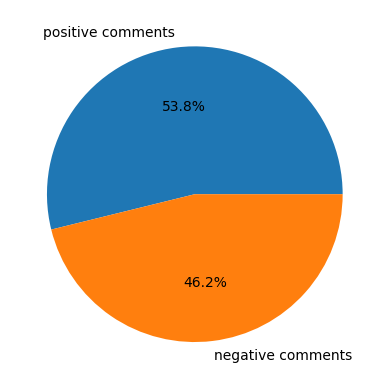

In [7]:
if __name__ == "__main__":
    #input url
    url = input("Enter your url:")
    
    #scraping comment from url
    df = ScrapComment(url)
    df = pd.read_csv("test.csv")
    
    #pre-processing of the text
    df = text_preprocessing(df)
    print (df)
    
    Z = df['clean_comments']
    Z = Z.reset_index(drop=True)

    #opening bag of words we have created and finding P(c) as prior_pos and P(n) as prior_neg
    bag = pd.read_csv("bag.csv", index_col=[0])
    prior = pd.read_csv("prior.csv", index_col=[0])

    prior_pos = prior.iloc[0]['prior']  # prior probability for  class
    prior_neg = prior.iloc[1]['prior']  #prior probability for class 

    #print(prior_pos,prior_neg)

    z_predicted = naive_bayes_predict(Z, bag, prior_pos, prior_neg)
    #z_predicted

    #saving predicted sentiments into dataframe and to csv
    df['sentiments'] = z_predicted
    df.to_csv("C:\\Users\\Madan\\Desktop\\projects\\sentimentanalysis\\predected_comments\\"+"temp.csv")

    #analysis of comments
    length = len(df)  # finding out length of the datframe
    pos_count = len(df[df['sentiments'] == 1])  # counting positive_sentiments
    neg_count = len(df[df['sentiments'] == 0])  # counting negative_sentiments
    print ('length=',length,'\npos_count',pos_count,'\nneg_count',neg_count,)

    y = np.array([pos_count,neg_count])
    mylabels = ["positive comments", "negative comments"]
    print(df)
    plt.pie(y, labels= mylabels,  autopct='%1.1f%%')
    plt.show() 
